<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li></ul></div>

#  Forecasting taxi orders

The Clear Taxi company has collected historical data on taxi orders at airports. In order to attract more drivers during the peak period, it is necessary to predict the number of taxi orders for the next hour. It is necessary to build a model for such a prediction, while the value of the *RMSE* metric on the test sample should not exceed 48.

Work plan:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters.
4. Check the data on the test sample and draw conclusions.

## Preparation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

import time

import warnings
warnings.filterwarnings("ignore")

#taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [2]:
taxi.info()
taxi.head(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


We loaded the data in the necessary way for time series analysis. Let's move on to resampling.

In [3]:
taxi = taxi.resample('1H').sum()

In [4]:
taxi.info()
taxi.head(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Resampling for one hour was carried out. We turn to the analysis of the prepared data.

## Analysis

In [5]:
taxi.index.is_monotonic

True

A successful check was made for the chronological order of the date and time.

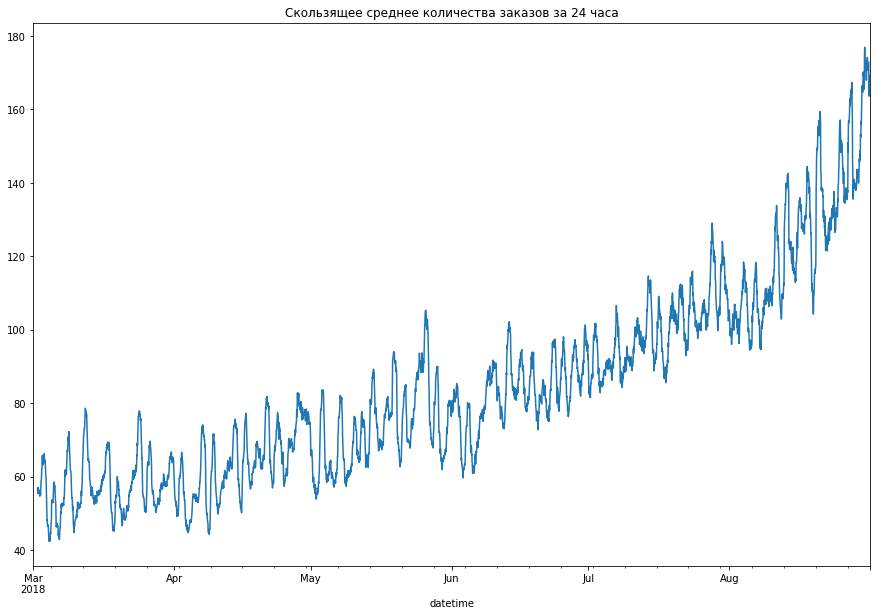

In [6]:
taxi['num_orders'].rolling(24).mean().plot(figsize=(15, 10))
plt.title('Скользящее среднее количества заказов за 24 часа')
plt.show()

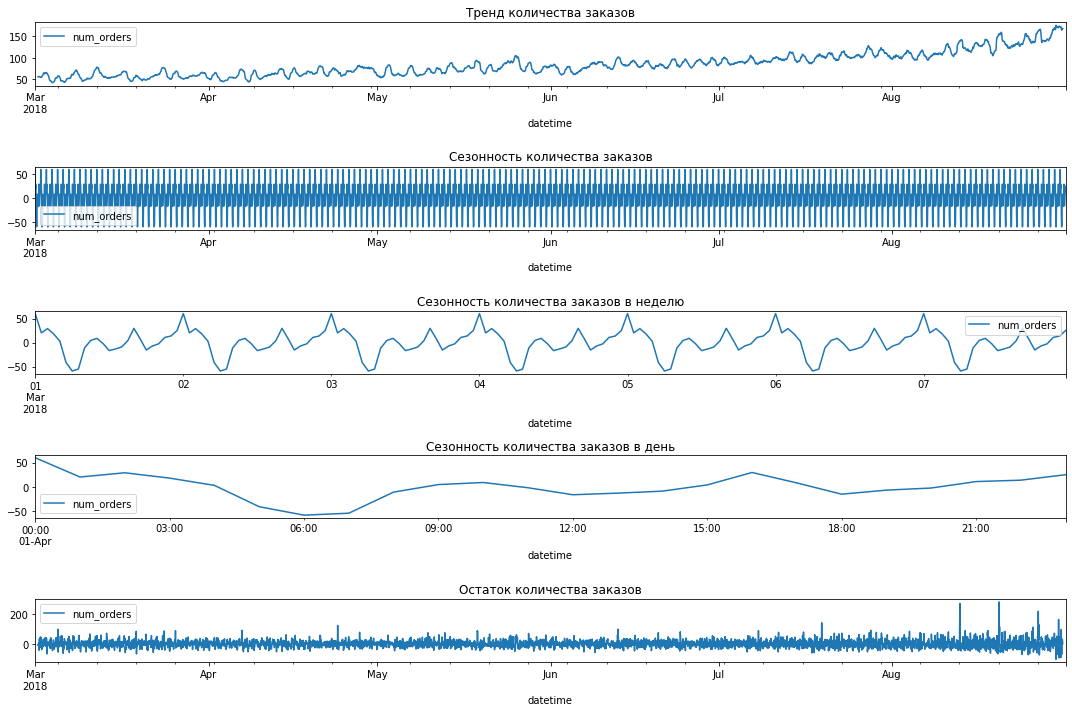

In [7]:
taxi_decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(15, 10))
plt.subplot(511)
taxi_decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд количества заказов')
plt.subplot(512)
taxi_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность количества заказов')
plt.subplot(513)
taxi_decomposed.seasonal['2018-03-01':'2018-03-7'].plot(ax=plt.gca())
plt.title('Сезонность количества заказов в неделю')
plt.subplot(514)
taxi_decomposed.seasonal['2018-04-01 00:00:00':'2018-04-1 23:00:00'].plot(ax=plt.gca())
plt.title('Сезонность количества заказов в день')
plt.subplot(515)
taxi_decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток количества заказов')
plt.tight_layout()

For analysis, a 24-hour moving average was displayed, and a resampling was carried out showing the overall seasonality of orders, the seasonality of the number of orders per week, and the seasonality of the number of orders per day.

The trend of the number of orders for 24 hours and the general trend are increasing, which indicates an increase in the number of orders for the entire period under review.

Graphs of different seasonality show their clear presence and repetition throughout the period under review.  Seasonality consists in the peak of orders on weekends with a decline in the middle of the week. During the day, the largest number of orders is observed at midnight with a minimum number in the early morning around 6-7 hours.

## Training

In [8]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df.iloc[:,0].shift(lag)

    df['rolling_mean'] = df.iloc[:,0].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(taxi, 2, 24)
taxi.dropna(inplace=True)
taxi.info()
taxi.head(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
num_orders      4392 non-null int64
dayofweek       4392 non-null int64
hour            4392 non-null int64
lag_1           4392 non-null float64
lag_2           4392 non-null float64
rolling_mean    4392 non-null float64
dtypes: float64(3), int64(3)
memory usage: 240.2 KB


,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,56.958333
2018-03-02 05:00:00,11,4,5,20.0,64.0,56.000000
2018-03-02 06:00:00,11,4,6,11.0,20.0,56.208333
2018-03-02 07:00:00,7,4,7,11.0,11.0,56.166667
2018-03-02 08:00:00,46,4,8,7.0,11.0,55.833333


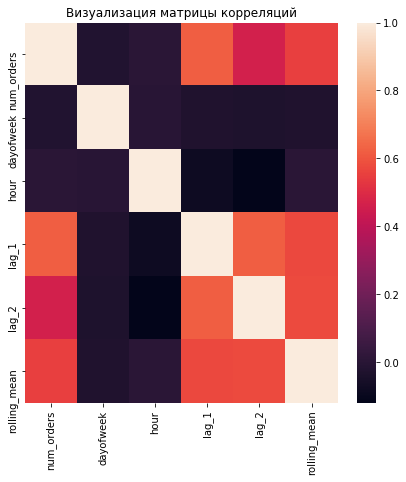

In [10]:
plt.figure(figsize=(7,7))
sns.heatmap(taxi.corr())
plt.title('Визуализация матрицы корреляций')
plt.show()

Let's create additional features using "lagging values". Since the basic seasonality was determined by us at the arrival at 24 hours, we will create a similar number of features. We visualize the correlation using the correlation matrix.

In [11]:
categorial = ['dayofweek', 'hour']
taxi[categorial] = taxi[categorial].astype('category')

In [12]:
features = taxi.drop('num_orders', axis=1)
target = taxi['num_orders']

In [13]:
taxi

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,56.958333
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667


Let's prepare the data by dividing it into features and target feature, as well as highlighting categorical features from features.

In [14]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.1, 
                                                                              shuffle=False)

In [15]:
print(f'Размерность features_train: {features_train.shape}, Размерность target_train: {target_train.shape}') 
print(f'Размерность features_test: {features_test.shape}, Размерность target_test: {target_test.shape}')

Размерность features_train: (3952, 5), Размерность target_train: (3952,)
Размерность features_test: (440, 5), Размерность target_test: (440,)


To split the data into two samples (training and test), the train_test_split method was used. The sampling ratio was 9:1 or 90%:210%. Dimension check completed successfully.

In [16]:
models_scores = pd.DataFrame(columns = ['model', 'rmse'])

Let's create a table of the results of the selection of the best models and proceed to the selection of the parameters of various models.

In [17]:
%%time
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
prediction = dummy.predict(features_test)
score_dummy = mean_squared_error(target_test, prediction) ** 0.5

print(f'RMSE для DummyRegressor: {score_dummy}')

models_scores = models_scores.append({'model': 'DummyRegressor', 'rmse': score_dummy}, ignore_index=True)

RMSE для DummyRegressor: 84.68768287118466
CPU times: user 2.62 ms, sys: 239 µs, total: 2.85 ms
Wall time: 2.7 ms


In [18]:
%%time
lr = LinearRegression()
lr.fit(features_train, target_train)
prediction = lr.predict(features_test)
score_lr = mean_squared_error(target_test, prediction) ** 0.5

print(f'RMSE для LinearRegression: {score_lr}')

models_scores = models_scores.append({'model': 'LinearRegression', 'rmse': score_lr}, ignore_index=True)

RMSE для LinearRegression: 51.29636818907293
CPU times: user 9.53 ms, sys: 1.67 ms, total: 11.2 ms
Wall time: 10.2 ms


In [19]:
%%time
LGBM = LGBMRegressor(categorical_feature=categorial, verbose=-1, random_state=12345)

parameters = {'max_depth': np.arange(1, 25, 1),
              'n_estimators': np.arange(1, 25, 1)}

LGBM_grid = GridSearchCV(LGBM, param_grid=parameters, scoring='neg_mean_squared_error', 
                         n_jobs=-1, cv=TimeSeriesSplit(n_splits=5), verbose=1)
LGBM_grid.fit(features_train, target_train)

print(f'Лучшие параметры модели LGBMRegressor: {LGBM_grid.best_params_}')

score_LGBM = abs(LGBM_grid.best_score_) ** 0.5

print(f'Лучший RMSE для LGBMRegressor: {score_LGBM}')

models_scores = models_scores.append({'model' : 'LGBMRegressor', 'rmse' : score_LGBM}, ignore_index=True)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Лучшие параметры модели LGBMRegressor: {'max_depth': 7, 'n_estimators': 24}
Лучший RMSE для LGBMRegressor: 25.991035820502443
CPU times: user 3.05 s, sys: 187 ms, total: 3.23 s
Wall time: 24.2 s


In [20]:
%%time
CB = CatBoostRegressor(cat_features=categorial, random_state=12345)

parameters = {'max_depth': np.arange(1, 16, 1),
              'n_estimators': np.arange(1, 25, 1)}

CB_grid = GridSearchCV(CB, param_grid=parameters, scoring='neg_mean_squared_error', 
                       n_jobs=-1, cv=TimeSeriesSplit(n_splits=5), verbose=1)
CB_grid.fit(features_train, target_train)

print(f'Лучшие параметры модели CatBoostRegressor: {CB_grid.best_params_}')

score_CB = abs(CB_grid.best_score_) ** 0.5

print(f'Лучший RMSE для CatBoostRegressor: {score_CB}')

models_scores = models_scores.append({'model' : 'CatBoostRegressor', 'rmse' : score_CB}, ignore_index=True)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Learning rate set to 0.5
0:	learn: 33.3376456	total: 55.6ms	remaining: 889ms
1:	learn: 27.9086803	total: 56.8ms	remaining: 426ms
2:	learn: 26.1674507	total: 57.7ms	remaining: 269ms
3:	learn: 25.2328944	total: 58.8ms	remaining: 191ms
4:	learn: 24.6984763	total: 59.6ms	remaining: 143ms
5:	learn: 24.3018508	total: 60.6ms	remaining: 111ms
6:	learn: 24.2149505	total: 61.7ms	remaining: 88.1ms
7:	learn: 24.0433899	total: 62.7ms	remaining: 70.6ms
8:	learn: 23.9732004	total: 63.7ms	remaining: 56.6ms
9:	learn: 23.7963552	total: 64.7ms	remaining: 45.3ms
10:	learn: 23.7205951	total: 65.7ms	remaining: 35.8ms
11:	learn: 23.6473414	total: 66.8ms	remaining: 27.8ms
12:	learn: 23.5703597	total: 67.8ms	remaining: 20.9ms
13:	learn: 23.5471618	total: 68.6ms	remaining: 14.7ms
14:	learn: 23.4234461	total: 69.4ms	remaining: 9.25ms
15:	learn: 23.3533008	total: 70.3ms	remaining: 4.39ms
16:	learn: 23.2384900	total: 71.2ms	remaining: 0us
Лучшие парам

The selection of the best models was successful. Let's proceed to the analysis of the results.

In [21]:
models_scores

,model,rmse
0,DummyRegressor,84.687683
1,LinearRegression,51.296368
2,LGBMRegressor,25.991036
3,CatBoostRegressor,26.699562


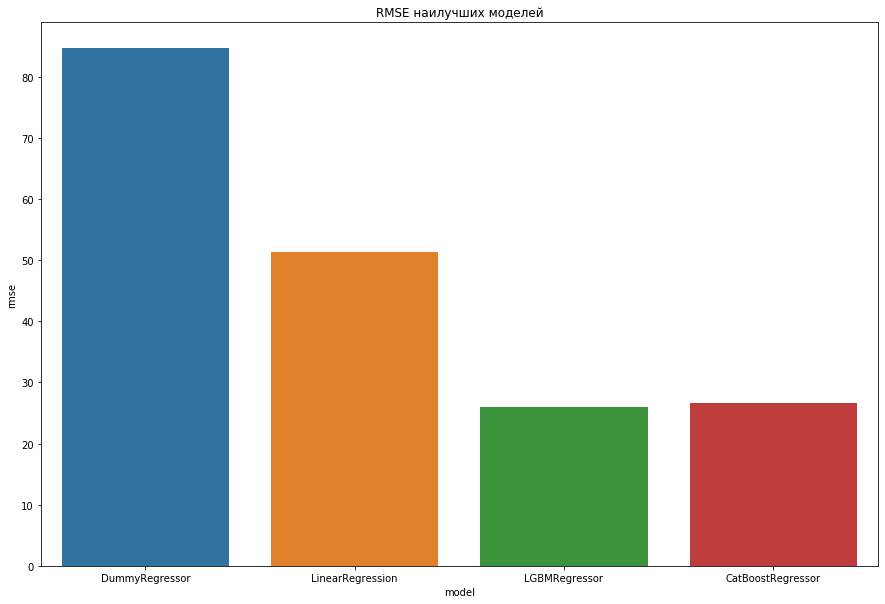

In [22]:
plt.figure(figsize=(15,10))
sns.barplot(x=models_scores['model'],y=models_scores['rmse'])
plt.title('RMSE наилучших моделей')
plt.show()

According to the selection results, the LGBMRegressor model showed the best result in terms of RMSE. It will be used for testing.

## Testing

In [23]:
print(f'Лучшие параметры модели LGBMRegressor: {LGBM_grid.best_params_}')

Лучшие параметры модели LGBMRegressor: {'max_depth': 7, 'n_estimators': 24}


In [24]:
prediction_test = LGBM_grid.best_estimator_.predict(features_test)

print(f'RMSE наилучшей модели на тестовой выборке: {mean_squared_error(prediction_test, target_test) ** 0.5}')

RMSE наилучшей модели на тестовой выборке: 45.30898373845717


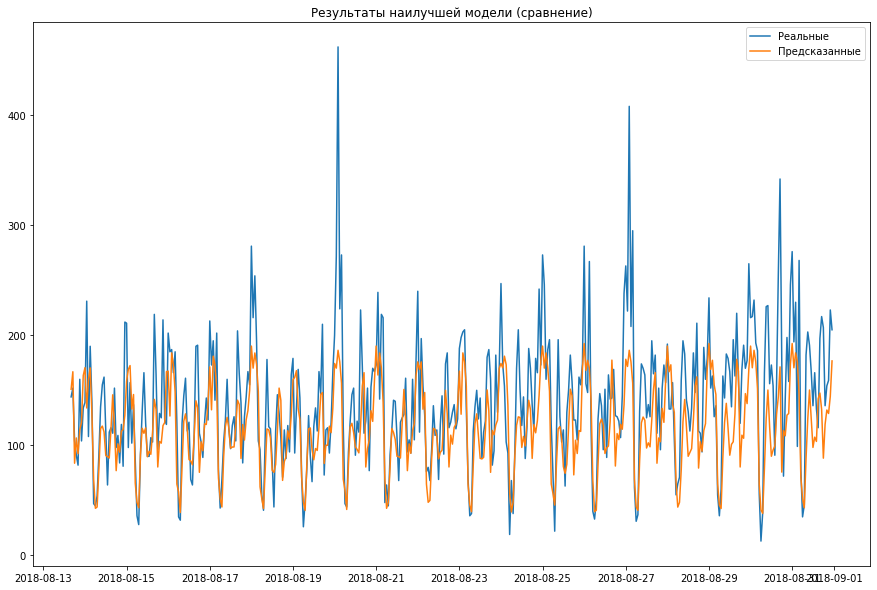

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(target_test, label='Реальные')
plt.plot(target_test.index, prediction_test, label='Предсказанные')
plt.title('Результаты наилучшей модели (сравнение)')
plt.legend()
plt.show()

The best LGBMRegressor model on the test sample showed RMSE in the amount of rounded 43.30, which is less than the threshold set by the Customer according to the terms of reference (48). The comparison plot results show that the predictions are much more consistent without outliers.

This model is recommended for use in predicting the number of taxi orders for the next hour.